Reinforcement Learning project
Action = (buy, sell)
Reward = based on the profit and loss from the previous trade.
State = Price and indicator value

In [2]:
pip install 'stable-baselines3==1.7.0' --force-reinstall

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'stable-baselines3==1.7.0'": Expected package name at the start of dependency specifier
    'stable-baselines3==1.7.0'
    ^


In [4]:
import numpy as np
import pandas as pd
import ta
import gymnasium
import stable_baselines3
import matplotlib.pyplot as plt
import pyfolio
import seaborn as sns

from gymnasium import spaces

from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import DDPG

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env

C:\Users\sagar\anaconda3\Lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [14]:
# Training the model using training data


class TradingEnv(gymnasium.Env):
    def __init__(self, data):
        super(TradingEnv, self).__init__()
        self.df = data
        self.reward_range = (-1, 1)
        
        # Action and observation spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=-8, high=6, shape=(11,), dtype=np.float32)
        
        self.current_step = None
        self.profit = None
        self.bought = None
        self.done = None
        self.seed_value = None  # To store the seed value
        self.reset()

    def reset(self, seed=None, options=None):
        # Handle seeding
        self.seed_value = seed
        super().reset(seed=seed)  # Call the parent class's reset method with the seed

        self.current_step = 0
        self.profit = 0
        self.bought = False
        self.done = False

        # Normalize observations
        obs = (
            self.df.iloc[self.current_step][
                ['SPY', 'SMA', 'RSI', 'CCI', 'ADX', 'MACD',
                 'fib_level1', 'fib_level2', 'fib_level3', 'fib_level4', 'fib_level5']
            ].values / self.df.max().values
        )

        # Return observation and an empty info dictionary
        return obs, {}


    def step(self, action):
        if action == 0:  # Buy
            if not self.bought:
                self.bought = True
                self.buy_price = self.df.iloc[self.current_step]['SPY']
        elif action == 1:  # Sell
            if self.bought:
                self.bought = False
                self.sell_price = self.df.iloc[self.current_step]['SPY']
                self.profit += (self.sell_price - self.buy_price) / self.buy_price

        self.current_step += 1

        # Determine if the episode is done or truncated
        terminated = self.current_step >= len(self.df)
        truncated = self.current_step >= 1000  # Example of truncation condition, replace with your logic if needed

        # Get the next observation
        obs = (
            self.df.iloc[self.current_step][
                ['SPY', 'SMA', 'RSI', 'CCI', 'ADX', 'MACD',
                 'fib_level1', 'fib_level2', 'fib_level3', 'fib_level4', 'fib_level5']
            ].values / self.df.max().values
        )
        reward = self.profit

        # Return the updated values
        return obs, reward, terminated, truncated, {}

   
    

df = pd.read_excel('SPY_training.xlsx')
df = df.astype(np.float32)

df['SMA'] = df['SPY'].rolling(window=20).mean()
df['RSI'] = ta.momentum.RSIIndicator(df['SPY'], window=20).rsi()
macd = ta.trend.MACD(df['SPY'])
df['MACD'] = macd.macd()
cci = ta.trend.cci(high = df['SPY'], low = df['SPY'], close = df['SPY'], window=20)
df['CCI'] = cci
adx = ta.trend.ADXIndicator(high=df['SPY'], low=df['SPY'], close=df['SPY'], window=20)
df['ADX'] = adx.adx()

#Fibonacci Retracement for support levels
high = df['SPY'].rolling(window=20).max()
low = df['SPY'].rolling(window=20).min()
diff = high - low
levels = [0.236, 0.382, 0.5, 0.618, 0.786]

fib_levels = []
for level in levels:
    fib = high - diff * level
    fib_levels.append(fib)

fib_level1 = fib_levels[0]
df['fib_level1'] = fib_level1
fib_level2 = fib_levels[1]
df['fib_level2'] = fib_level2
fib_level3 = fib_levels[2]
df['fib_level3'] = fib_level3
fib_level4 = fib_levels[3]
df['fib_level4'] = fib_level4
fib_level5 = fib_levels[4]
df['fib_level5'] = fib_level5


df.dropna(inplace=True)
df = df.astype(np.float32)

env = TradingEnv(df)
check_env(env)

env = DummyVecEnv([lambda: env])
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=4000)


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 641      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.331   |
|    explained_variance | -0.512   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0131   |
|    value_loss         | 0.0187   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 618      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.531   |
|    explained_variance | 0.447    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.163    |
|    value_loss      

In [23]:
# Testing the model using testing data
# Load the test data
test_data = pd.read_excel('SPY_testing.xlsx')
test_data = test_data.astype(np.float32)

test_data['SMA'] = test_data['SPY'].rolling(window=20).mean()
test_data['RSI'] = ta.momentum.RSIIndicator(test_data['SPY'], window=20).rsi()
macd = ta.trend.MACD(test_data['SPY'])
test_data['MACD'] = macd.macd()
cci = ta.trend.cci(high = test_data['SPY'], low = test_data['SPY'], close = test_data['SPY'], window=20)
test_data['CCI'] = cci
adx = ta.trend.ADXIndicator(high=test_data['SPY'], low=test_data['SPY'], close=test_data['SPY'], window=20)
test_data['ADX'] = adx.adx()

high = test_data['SPY'].rolling(window=20).max()
low = test_data['SPY'].rolling(window=20).min()
diff = high - low
levels = [0.236, 0.382, 0.5, 0.618, 0.786]

fib_levels = []
for level in levels:
    fib = high - diff * level
    fib_levels.append(fib)

fib_level1 = fib_levels[0]
test_data['fib_level1'] = fib_level1
fib_level2 = fib_levels[1]
test_data['fib_level2'] = fib_level2
fib_level3 = fib_levels[2]
test_data['fib_level3'] = fib_level3
fib_level4 = fib_levels[3]
test_data['fib_level4'] = fib_level4
fib_level5 = fib_levels[4]
test_data['fib_level5'] = fib_level5


test_data.dropna(inplace=True)
test_data = test_data.astype(np.float32)

# Initialize the trading environment
test_env = TradingEnv(test_data)
test_env = DummyVecEnv([lambda: test_env])

# Run the test
obs = test_env.reset()
done = False
profits = []
actions = []

k = 0
while k!=len(test_data)-1:
    action, _ = model.predict(obs)
    obs, reward, done, info = test_env.step(action)
    if not done:
        profits.append(reward)
        actions.append(action)
    k=k+1

cumulative_profits = np.cumsum(profits)




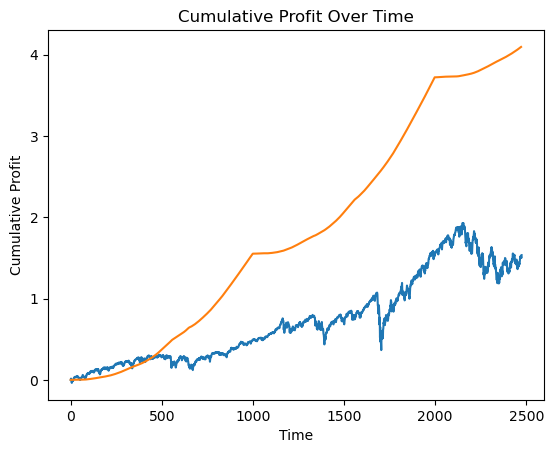

Sharpe ratio of Buy-Hold SPY: 0.6254743877469502
Sharpe ratio of A2C trading strategy SPY: 1.3577651


In [24]:
SPY_benchmark = test_data['SPY']
SPY_benchmark_temp = test_data['SPY'].tolist()
buy_and_hold = [(val - SPY_benchmark_temp[0])/SPY_benchmark_temp[0] for val in SPY_benchmark_temp]


plt.plot(buy_and_hold, label="SPY Returns")
plt.plot(cumulative_profits/100, label=" A2C Returns")
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.show()


SPY_returns = test_data['SPY'].pct_change().dropna()
SPY_sharpe_ratio = np.sqrt(252) * SPY_returns.mean() / SPY_returns.std()
print("Sharpe ratio of Buy-Hold SPY:",SPY_sharpe_ratio)

Strategy_sharpe_ratio = np.diff(cumulative_profits).mean() / np.diff(cumulative_profits).std()
print("Sharpe ratio of A2C trading strategy SPY:",Strategy_sharpe_ratio)

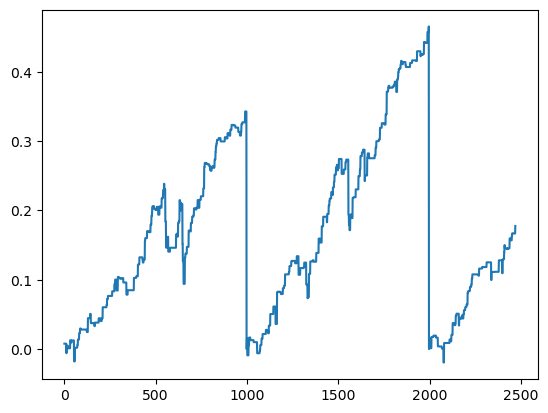

In [25]:
plt.plot(np.diff(cumulative_profits), label=" A2C Returns")

In [33]:
# Check lengths
print(f"Length of cumulative_profits after np.diff: {len(np.diff(cumulative_profits/100))}")
# print(f"Length of dates: {len(dates)}")

Length of cumulative_profits after np.diff: 2471


In [35]:
# Calculate daily returns using percentage change formula

start_date = '2016-07-06'
end_date = '2023-04-13'
dates = pd.date_range(start=start_date, end=end_date, freq='D')

SPY_benchmark = test_data['SPY']
#daily_returns = SPY_benchmark.pct_change().values
SPY_daily_returns = [(val - SPY_benchmark.values[0])/SPY_benchmark.values[0] for val in SPY_benchmark]
mask = ~np.isnan(SPY_daily_returns)
#daily_returns = daily_returns[mask]

SPY_Sharpe_Ratio = (252**0.5)*np.array(SPY_daily_returns).mean()/np.array(SPY_daily_returns).std()
# A2C_returns_series = pd.Series((np.diff(cumulative_profits/100)).astype(float), index=dates[0:])

# SPY_daily_returns_series = pd.Series(SPY_daily_returns[2:], index=dates[0:])
# SPY_daily_returns_series.index = pd.to_datetime(SPY_daily_returns_series.index.strftime('%Y-%m-%d'))

# A2C_returns_series.index = pd.to_datetime(A2C_returns_series.index.strftime('%Y-%m-%d'))


# Trim the dates array to match the length of np.diff(cumulative_profits/100)
A2C_returns_series = pd.Series(
    (np.diff(cumulative_profits / 100)).astype(float),
    index=dates[: len(np.diff(cumulative_profits / 100))]
)

# Similarly, adjust SPY_daily_returns_series
SPY_daily_returns_series = pd.Series(
    SPY_daily_returns[2:],
    index=dates[: len(SPY_daily_returns[2:])]
)

# Convert to datetime format
SPY_daily_returns_series.index = pd.to_datetime(SPY_daily_returns_series.index.strftime('%Y-%m-%d'))
A2C_returns_series.index = pd.to_datetime(A2C_returns_series.index.strftime('%Y-%m-%d'))

# Debug lengths to confirm
print(f"Length of A2C_returns_series: {len(A2C_returns_series)}")
print(f"Length of SPY_daily_returns_series: {len(SPY_daily_returns_series)}")

Length of A2C_returns_series: 2471
Length of SPY_daily_returns_series: 2473


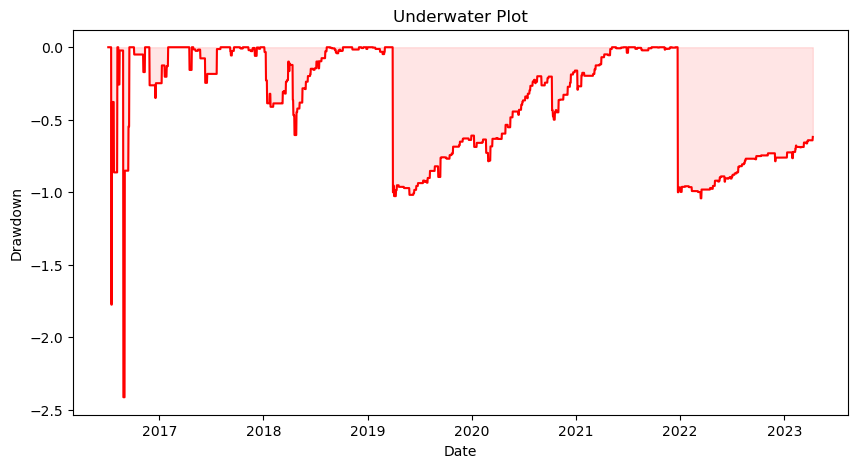

In [37]:

# Define a function to calculate drawdowns
def drawdown(A2C_returns_series):
    max_return = np.maximum.accumulate(A2C_returns_series)
    return (A2C_returns_series - max_return) / max_return

# Calculate drawdowns
dd = drawdown(A2C_returns_series)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dd, color='red')
ax.fill_between(dd.index, dd, 0, color='red', alpha=0.1)
ax.set(title='Underwater Plot', xlabel='Date', ylabel='Drawdown')
plt.show()


C:\Users\sagar\AppData\Local\Temp\ipykernel_3148\2775408619.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = A2C_returns_series.resample('Y').last().pct_change()


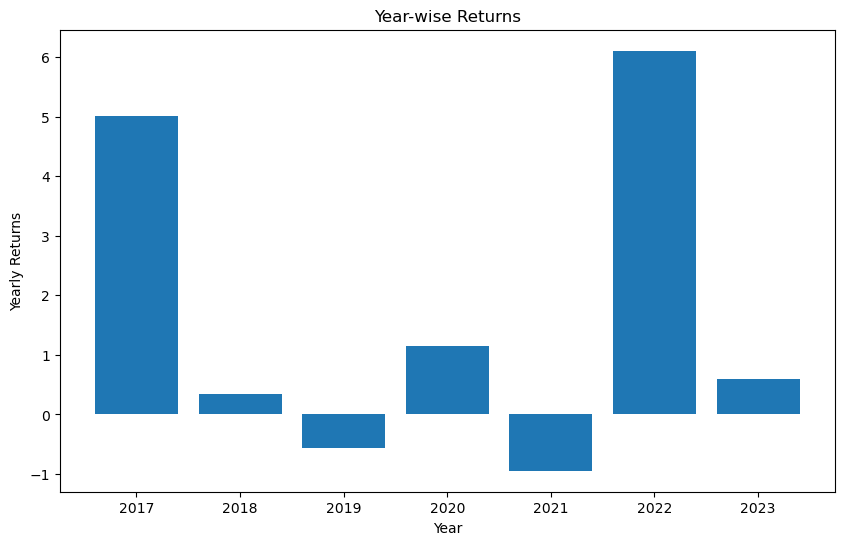

In [39]:
yearly_returns = A2C_returns_series.resample('Y').last().pct_change()

# Plot the yearly returns
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(yearly_returns.index.year, yearly_returns.values)
ax.set_xlabel('Year')
ax.set_ylabel('Yearly Returns')
ax.set_title('Year-wise Returns')
plt.show()